<a href="https://colab.research.google.com/github/saahil-jain/Covid_19_predictor/blob/master/CasesDeathsLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from copy import deepcopy

import pickle

print(os.getcwd())
if os.getcwd().split("/")[-1] == "Covid_19_predictor":
  print("Current working directory is already Covid_19_predictor")
elif os.path.isdir("Covid_19_predictor"):
  print("Covid_19_predictor already Exists")
else:
  ! git clone https://github.com/saahil-jain/Covid_19_predictor.git

/content
Covid_19_predictor already Exists


In [2]:
if os.path.isdir("Covid_19_predictor"):
  % cd Covid_19_predictor
! git pull

/content/Covid_19_predictor
Already up to date.


In [3]:
df = pd.read_csv("data.csv")
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,05/06/2020,5,6,2020,787,6,Afghanistan,AF,AFG,37172386.0,Asia
1,04/06/2020,4,6,2020,758,24,Afghanistan,AF,AFG,37172386.0,Asia
2,03/06/2020,3,6,2020,759,5,Afghanistan,AF,AFG,37172386.0,Asia
3,02/06/2020,2,6,2020,545,8,Afghanistan,AF,AFG,37172386.0,Asia
4,01/06/2020,1,6,2020,680,8,Afghanistan,AF,AFG,37172386.0,Asia


In [4]:
grouped = df.groupby('countriesAndTerritories')
countries = sorted(list(set(df.countriesAndTerritories.unique())))
country_population = {}
for country in countries:
  country_population[country] = set(grouped.get_group(country)['popData2018'])
countries_to_remove = ["Cases_on_an_international_conveyance_Japan", "Holy_See"]
for country in countries:
  if len(country_population[country])>1 :
    countries_to_remove.append(country)
for country in countries_to_remove:
  del country_population[country]
  countries.remove(country)

country_population = {}
for country in countries:
  country_population[country] = list(grouped.get_group(country)['popData2018'])[0]

In [5]:
country_wise_cases = dict()
country_wise_deaths = dict()
normalised_country_wise_cases = dict()
normalised_country_wise_deaths = dict()
for country in countries:
  country_wise_cases[country] = list(grouped.get_group(country)['cases'])[::-1]
  country_wise_deaths[country] = list(grouped.get_group(country)['deaths'])[::-1]
for country in countries:
  for index in range(len(country_wise_cases[country])):
    country_wise_cases[country][index] = abs(country_wise_cases[country][index])
    country_wise_deaths[country][index] = abs(country_wise_deaths[country][index])

for country in countries:
  leading_zero_count = 0
  for index in range(len(country_wise_cases[country])):
    if country_wise_cases[country][index] == 0:
      leading_zero_count += 1
    else:
      country_wise_cases[country] = country_wise_cases[country][leading_zero_count:]
      country_wise_deaths[country] = country_wise_deaths[country][leading_zero_count:]
      break

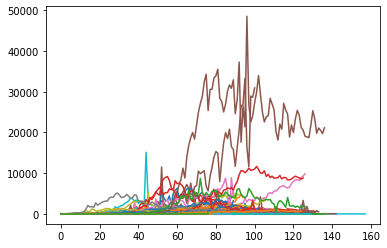

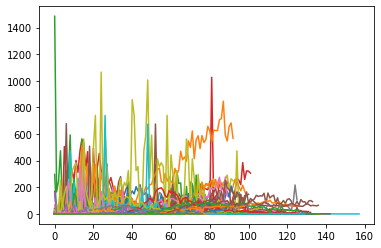

In [6]:
for country in countries:
  graph = plt.plot(country_wise_cases[country])
plt.show()

for country in countries:
  normalised_country_wise_cases[country] = deepcopy(country_wise_cases[country])
  for index in range(len(country_wise_cases[country])):
    normalised_country_wise_cases[country][index] = normalised_country_wise_cases[country][index] * 1_000_000 / country_population[country]
  graph=plt.plot(normalised_country_wise_cases[country])
plt.show()

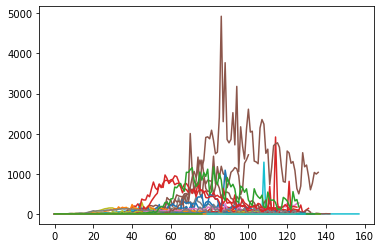

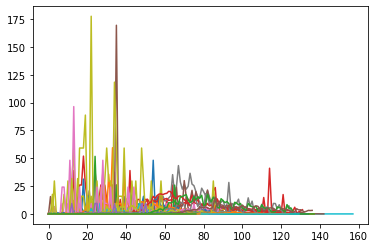

In [7]:
for country in countries:
  graph = plt.plot(country_wise_deaths[country])
plt.show()

for country in countries:
  normalised_country_wise_deaths[country] = deepcopy(country_wise_deaths[country])
  for index in range(len((country_wise_deaths[country]))):
    normalised_country_wise_deaths[country][index] = normalised_country_wise_deaths[country][index] * 1_000_000 / country_population[country]
  graph = plt.plot(normalised_country_wise_deaths[country])
plt.show()

In [8]:
cumulative_country_wise_cases = dict()
cumulative_country_wise_deaths = dict()
normalised_cumulative_country_wise_cases = dict()
normalised_cumulative_country_wise_deaths = dict()

for country in countries:
  cumulative_country_wise_cases[country] = []
  cumulative_country_wise_deaths[country] = []
  cumulative_cases = 0
  cumulative_death = 0
  normalised_cumulative_country_wise_cases[country] = []
  normalised_cumulative_country_wise_deaths[country] = []
  normalised_cumulative_cases = 0
  normalised_cumulative_death = 0
  total_days = len(country_wise_cases[country])
  for index in range(total_days):
    cumulative_cases += country_wise_cases[country][index]
    cumulative_death += country_wise_deaths[country][index]
    cumulative_country_wise_cases[country].append(cumulative_cases)
    cumulative_country_wise_deaths[country].append(cumulative_death)
    normalised_cumulative_cases += normalised_country_wise_cases[country][index]
    normalised_cumulative_death += normalised_country_wise_deaths[country][index]
    normalised_cumulative_country_wise_cases[country].append(normalised_cumulative_cases)
    normalised_cumulative_country_wise_deaths[country].append(normalised_cumulative_death)

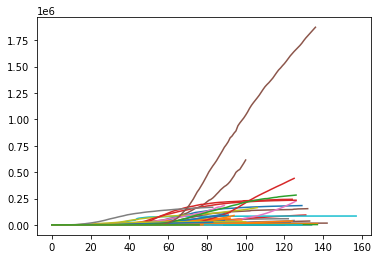

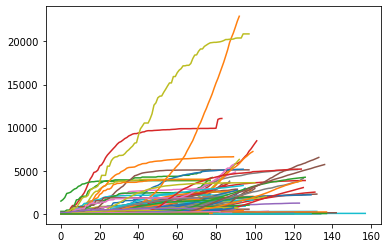

In [9]:
for country in countries:
  graph = plt.plot(cumulative_country_wise_cases[country])
plt.show()

for country in countries:
  graph = plt.plot(normalised_cumulative_country_wise_cases[country])
plt.show()

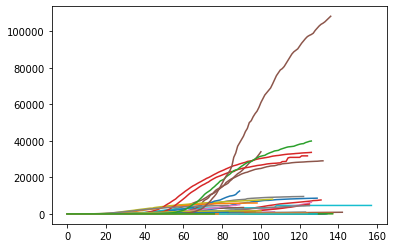

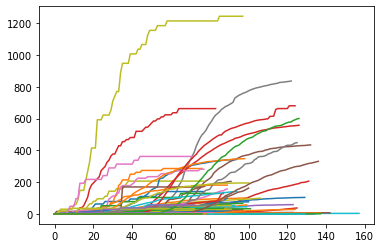

In [10]:
for country in countries:
  graph = plt.plot(cumulative_country_wise_deaths[country])
plt.show()

for country in countries:
  graph = plt.plot(normalised_cumulative_country_wise_deaths[country])
plt.show()

In [11]:
for country in countries:
  print("{0:45s}".format(country),"{0:10d}".format(cumulative_country_wise_cases[country][-1]),"{0:10d}".format(cumulative_country_wise_deaths[country][-1]))

Afghanistan                                        18054        300
Albania                                             1197         33
Algeria                                             9831        681
Andorra                                              852         51
Angola                                                86          4
Antigua_and_Barbuda                                   26          3
Argentina                                          19255        588
Armenia                                            11221        176
Aruba                                                101          3
Australia                                           7240        102
Austria                                            16741        670
Azerbaijan                                          6522         78
Bahamas                                              102         11
Bahrain                                            13296         21
Bangladesh                                      

In [12]:
top_n = 10
countries_and_cases=[]
countries_and_deaths=[]

for country, cumulative_cases in zip(cumulative_country_wise_cases.keys(), cumulative_country_wise_cases.values()):
  countries_and_cases.append([country, cumulative_cases[-1]])
countries_and_cases = sorted(countries_and_cases,key = lambda x:x[1],reverse=True)
top_n_cases = list(map(lambda x:x[0], countries_and_cases))[:top_n]

for country, cumulative_deaths in zip(cumulative_country_wise_deaths.keys(), cumulative_country_wise_deaths.values()):
  countries_and_deaths.append([country, cumulative_deaths[-1]])
countries_and_deaths = sorted(countries_and_deaths, key = lambda x:x[1], reverse = True)

top_n_deaths = list(map(lambda x:x[0],countries_and_deaths))[:top_n]

print("{0:45s}".format("Total Cases"), "{0:45s}".format("Total Deaths"), end="\n\n")
for index in range(top_n):
  print("{0:45s}".format(top_n_cases[index]), "{0:45s}".format(top_n_deaths[index]))

Total Cases                                   Total Deaths                                 

United_States_of_America                      United_States_of_America                     
Brazil                                        United_Kingdom                               
Russia                                        Brazil                                       
United_Kingdom                                Italy                                        
Spain                                         Spain                                        
Italy                                         France                                       
India                                         Mexico                                       
Germany                                       Belgium                                      
Peru                                          Germany                                      
Turkey                                        Iran                             

In [13]:
def intersection(lst1, lst2): 
  return list(set(lst1) & set(lst2)) 
training_countries = list(intersection(top_n_cases, top_n_deaths))
print(training_countries)

['United_States_of_America', 'United_Kingdom', 'Brazil', 'Germany', 'Spain', 'Italy']


In [14]:
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [15]:
def return_rmse(test,predicted):
  rmse = math.sqrt(mean_squared_error(test, predicted))
  print("The root mean squared error is {}.".format(rmse))

In [16]:
base_data_cases = normalised_country_wise_cases
base_data_deaths = normalised_country_wise_deaths

def split(dataframe, split_factor):
  base_data = {}
  for country in training_countries:
    base_data[country] = {}
    country_data_length = len(dataframe[country])
    split_index = int(math.floor(country_data_length * split_factor))
    base_data[country]["Train"] = dataframe[country][:split_index]
    base_data[country]["Test"] = dataframe[country][split_index:]
  return base_data

split_factor = 0.8

transform_train_cases = {}
transform_test_cases = {}
scaler_cases = {}
data_cases = split(base_data_cases, split_factor)
for num, country in enumerate(training_countries):
  sc = MinMaxScaler(feature_range=(0,1))
  a0 = np.array(data_cases[country]["Train"])
  a1 = np.array(data_cases[country]["Test"])
  a0 = a0.reshape(a0.shape[0],1)
  a1 = a1.reshape(a1.shape[0],1)
  transform_train_cases[country] = sc.fit_transform(a0)
  transform_test_cases[country] = sc.fit_transform(a1)
  scaler_cases[country] = sc
del a0
del a1

transform_train_deaths = {}
transform_test_deaths = {}
scaler_deaths = {}
data_deaths = split(base_data_deaths, split_factor)
for num, country in enumerate(training_countries):
  sc = MinMaxScaler(feature_range=(0,1))
  a0 = np.array(data_deaths[country]["Train"])
  a1 = np.array(data_deaths[country]["Test"])
  a0 = a0.reshape(a0.shape[0],1)
  a1 = a1.reshape(a1.shape[0],1)
  transform_train_deaths[country] = sc.fit_transform(a0)
  transform_test_deaths[country] = sc.fit_transform(a1)
  scaler_deaths[country] = sc
del a0
del a1

In [17]:
for i in transform_train_cases.keys():
    print(i, transform_train_cases[i].shape)
print("\n")    
for i in transform_test_cases.keys():
    print(i, transform_test_cases[i].shape)
 
print("\n")    
for i in transform_train_deaths.keys():
    print(i, transform_train_deaths[i].shape)
print("\n")    
for i in transform_test_deaths.keys():
    print(i, transform_test_deaths[i].shape)

United_States_of_America (109, 1)
United_Kingdom (101, 1)
Brazil (80, 1)
Germany (104, 1)
Spain (100, 1)
Italy (101, 1)


United_States_of_America (28, 1)
United_Kingdom (26, 1)
Brazil (21, 1)
Germany (26, 1)
Spain (25, 1)
Italy (26, 1)


United_States_of_America (109, 1)
United_Kingdom (101, 1)
Brazil (80, 1)
Germany (104, 1)
Spain (100, 1)
Italy (101, 1)


United_States_of_America (28, 1)
United_Kingdom (26, 1)
Brazil (21, 1)
Germany (26, 1)
Spain (25, 1)
Italy (26, 1)


In [18]:
trainset_cases = {}
testset_cases = {}
look_back_cases = 3
for country in training_countries:
    trainset_cases[country] = {}
    X_train = []
    y_train = []
    for i in range(look_back_cases, len(transform_train_cases[country])):
      X_train.append(transform_train_cases[country][i-look_back_cases:i,0])
      y_train.append(transform_train_cases[country][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset_cases[country]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset_cases[country]["y"] = y_train
    
    testset_cases[country] = {}
    X_test = []
    y_test = []    
    for i in range(look_back_cases, len(transform_test_cases[country])):
      X_test.append(transform_test_cases[country][i-look_back_cases:i,0])
      y_test.append(transform_test_cases[country][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset_cases[country]["X"] = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    testset_cases[country]["y"] = y_test

trainset_deaths = {}
testset_deaths = {}
look_back_deaths = 3
for country in training_countries:
    trainset_deaths[country] = {}
    X_train = []
    y_train = []
    for i in range(look_back_deaths, len(transform_train_deaths[country])):
      X_train.append(transform_train_deaths[country][i-look_back_deaths:i,0])
      y_train.append(transform_train_deaths[country][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset_deaths[country]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset_deaths[country]["y"] = y_train
    
    testset_deaths[country] = {}
    X_test = []
    y_test = []    
    for i in range(look_back_deaths, len(transform_test_deaths[country])):
      X_test.append(transform_test_deaths[country][i-look_back_deaths:i,0])
      y_test.append(transform_test_deaths[country][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset_deaths[country]["X"] = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    testset_deaths[country]["y"] = y_test

In [19]:
arr_buff_cases = []
for country in training_countries:
  buff = {}
  buff["X_train"] = trainset_cases[country]["X"].shape
  buff["y_train"] = trainset_cases[country]["y"].shape
  buff["X_test"] = testset_cases[country]["X"].shape
  buff["y_test"] = testset_cases[country]["y"].shape
  arr_buff_cases.append(buff)

pd.DataFrame(arr_buff_cases, index=training_countries)

,X_train,y_train,X_test,y_test
United_States_of_America,"(106, 3, 1)","(106,)","(25, 3, 1)","(25,)"
United_Kingdom,"(98, 3, 1)","(98,)","(23, 3, 1)","(23,)"
Brazil,"(77, 3, 1)","(77,)","(18, 3, 1)","(18,)"
Germany,"(101, 3, 1)","(101,)","(23, 3, 1)","(23,)"
Spain,"(97, 3, 1)","(97,)","(22, 3, 1)","(22,)"
Italy,"(98, 3, 1)","(98,)","(23, 3, 1)","(23,)"


In [20]:
arr_buff_deaths = []
for country in training_countries:
  buff = {}
  buff["X_train"] = trainset_deaths[country]["X"].shape
  buff["y_train"] = trainset_deaths[country]["y"].shape
  buff["X_test"] = testset_deaths[country]["X"].shape
  buff["y_test"] = testset_deaths[country]["y"].shape
  arr_buff_deaths.append(buff)

pd.DataFrame(arr_buff_deaths, index=training_countries)

,X_train,y_train,X_test,y_test
United_States_of_America,"(106, 3, 1)","(106,)","(25, 3, 1)","(25,)"
United_Kingdom,"(98, 3, 1)","(98,)","(23, 3, 1)","(23,)"
Brazil,"(77, 3, 1)","(77,)","(18, 3, 1)","(18,)"
Germany,"(101, 3, 1)","(101,)","(23, 3, 1)","(23,)"
Spain,"(97, 3, 1)","(97,)","(22, 3, 1)","(22,)"
Italy,"(98, 3, 1)","(98,)","(23, 3, 1)","(23,)"


In [21]:
total_error = dict()
total_error["Cases"] = 0
total_error["Deaths"] = 0
  
def lagging(df, lag):
  df_pred = pd.Series(df["Pred"].reshape(-1))
  df_true = pd.Series(df["True"].reshape(-1))
   
  df_pred_lag = df_pred.shift(lag)
    
  MSE_lag = mean_squared_error(np.array(df_true[:-lag]), np.array(df_pred_lag[:-lag]))
  print("MSE with Lag    :", MSE_lag)

  plt.figure(figsize=(14,4))
  plt.title("Prediction with Lag")
  plt.plot(df_true, color='green')
  plt.plot(df_pred_lag, color='blue')
  plt.legend(["True", "Predicted"])

  return MSE_lag

Fitting to United_States_of_America
Epoch 1/1
106/106 [==============================] - 1s 11ms/step - loss: 0.1073 - accuracy: 0.1981
Fitting to United_Kingdom
Epoch 1/1
98/98 [==============================] - 0s 598us/step - loss: 0.0630 - accuracy: 0.2041
Fitting to Brazil
Epoch 1/1
77/77 [==============================] - 0s 545us/step - loss: 0.0434 - accuracy: 0.0779
Fitting to Germany
Epoch 1/1
101/101 [==============================] - 0s 542us/step - loss: 0.0509 - accuracy: 0.1881
Fitting to Spain
Epoch 1/1
97/97 [==============================] - 0s 558us/step - loss: 0.0274 - accuracy: 0.2165
Fitting to Italy
Epoch 1/1
98/98 [==============================] - 0s 577us/step - loss: 0.0315 - accuracy: 0.1939
Fitting to United_States_of_America
Epoch 1/1
106/106 [==============================] - 0s 554us/step - loss: 0.0217 - accuracy: 0.1981
Fitting to United_Kingdom
Epoch 1/1
98/98 [==============================] - 0s 642us/step - loss: 0.0178 - accuracy: 0.2143
Fitting 

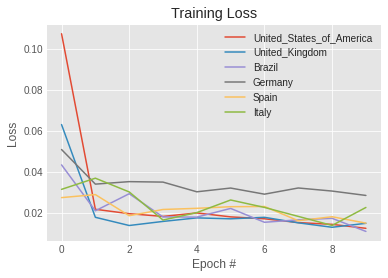

In [22]:
%%time
epochs = 10
# The LSTM architecture
regressorLSTM_cases = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM_cases.add(LSTM(units=50, return_sequences=True, input_shape=(look_back_cases,1)))
regressorLSTM_cases.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM_cases.add(LSTM(units=50, return_sequences=True))
regressorLSTM_cases.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM_cases.add(LSTM(units=50, return_sequences=True))
regressorLSTM_cases.add(Dropout(0.5))
# Fourth LSTM layer
regressorLSTM_cases.add(LSTM(units=50))
regressorLSTM_cases.add(Dropout(0.5))
# The output layer
regressorLSTM_cases.add(Dense(units=1))

# Compiling the LSTM
regressorLSTM_cases.compile(optimizer='rmsprop', loss='mean_squared_error', metrics = ['accuracy'])
# Fitting to the training set
history_cases = {}
accuracy_cases = {}
for country in training_countries:
  history_cases[country] = []
  accuracy_cases[country] = []
for epoch in range(epochs):
    for country in training_countries:
        print("Fitting to", country)
        H = regressorLSTM_cases.fit(trainset_cases[country]["X"], trainset_cases[country]["y"], epochs=1, batch_size=16)
        history_cases[country].append(H.history["loss"])
        accuracy_cases[country].append(H.history["accuracy"])
print(history_cases)

plt.style.use("ggplot")
plt.figure()
for country in training_countries:
  plt.plot(np.arange(0, epochs), history_cases[country], label=country)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [23]:
print("ACCURACIES\n")
total_accuracy = {}
tot_cases = 0
for country in training_countries:
  sum = 0
  for i in range(len(accuracy_cases[country])):
    sum += accuracy_cases[country][i][0]
  avg = sum/(len(accuracy_cases[country]))
  tot_cases += avg
  print(country)
  print(avg)
tot_cases/=len(training_countries)
total_accuracy['cases'] = tot_cases

ACCURACIES

United_States_of_America
0.19811320304870605
United_Kingdom
0.21122449338436128
Brazil
0.08181818127632141
Germany
0.19405940771102906
Spain
0.2164948433637619
Italy
0.20306123048067093


Fitting to United_States_of_America
Epoch 1/1
106/106 [==============================] - 1s 11ms/step - loss: 0.0512 - accuracy: 0.3585
Fitting to United_Kingdom
Epoch 1/1
98/98 [==============================] - 0s 702us/step - loss: 0.1016 - accuracy: 0.3571
Fitting to Brazil
Epoch 1/1
77/77 [==============================] - 0s 708us/step - loss: 0.0515 - accuracy: 0.2338
Fitting to Germany
Epoch 1/1
101/101 [==============================] - 0s 755us/step - loss: 0.0546 - accuracy: 0.4356
Fitting to Spain
Epoch 1/1
97/97 [==============================] - 0s 691us/step - loss: 0.0363 - accuracy: 0.3505
Fitting to Italy
Epoch 1/1
98/98 [==============================] - 0s 697us/step - loss: 0.0339 - accuracy: 0.2245
Fitting to United_States_of_America
Epoch 1/1
106/106 [==============================] - 0s 742us/step - loss: 0.0252 - accuracy: 0.3585
Fitting to United_Kingdom
Epoch 1/1
98/98 [==============================] - 0s 691us/step - loss: 0.0365 - accuracy: 0.3673
Fitting 

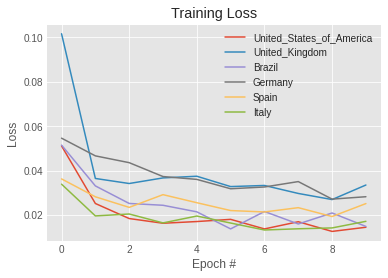

In [24]:
%%time
# epochs = 5
# The LSTM architecture
regressorLSTM_deaths = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM_deaths.add(LSTM(units=50, return_sequences=True, input_shape=(look_back_deaths,1)))
regressorLSTM_deaths.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM_deaths.add(LSTM(units=50, return_sequences=True))
regressorLSTM_deaths.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM_deaths.add(LSTM(units=50, return_sequences=True))
regressorLSTM_deaths.add(Dropout(0.5))
# Fourth LSTM layer
regressorLSTM_deaths.add(LSTM(units=50))
regressorLSTM_deaths.add(Dropout(0.5))
# The output layer
regressorLSTM_deaths.add(Dense(units=1))

# Compiling the LSTM
regressorLSTM_deaths.compile(optimizer='rmsprop', loss='mean_squared_error', metrics = ['accuracy'])
# Fitting to the training set
history_deaths = {}
accuracy_deaths = {}
for country in training_countries:
  history_deaths[country] = []
  accuracy_deaths[country] = []
for epoch in range(epochs):
    for country in training_countries:
        print("Fitting to", country)
        H = regressorLSTM_deaths.fit(trainset_deaths[country]["X"], trainset_deaths[country]["y"], epochs=1, batch_size=16)
        history_deaths[country].append(H.history["loss"])
        accuracy_deaths[country].append(H.history["accuracy"])
print(history_deaths)

plt.style.use("ggplot")
plt.figure()
for country in training_countries:
  plt.plot(np.arange(0, epochs), history_deaths[country], label=country)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [25]:
print("ACCURACIES\n")
tot_deaths = 0
for country in training_countries:
  sum = 0
  for i in range(len(accuracy_deaths[country])):
    sum += accuracy_deaths[country][i][0]
  avg = sum/(len(accuracy_deaths[country]))
  tot_deaths += avg
  print(country)
  print(avg)
tot_deaths/=len(training_countries)
total_accuracy['deaths'] = tot_deaths

ACCURACIES

United_States_of_America
0.35849055647850037
United_Kingdom
0.3653061270713806
Brazil
0.24545454382896423
Germany
0.4336633563041687
Spain
0.3494845271110535
Italy
0.2234693855047226


In [26]:
pred_result_cases = {}
for country in training_countries:
    y_true = scaler_cases[country].inverse_transform(testset_cases[country]["y"].reshape(-1,1))
    y_pred = scaler_cases[country].inverse_transform(regressorLSTM_cases.predict(testset_cases[country]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result_cases[country] = {}
    pred_result_cases[country]["True"] = y_true
    pred_result_cases[country]["Pred"] = y_pred

pred_result_deaths = {}
for country in training_countries:
    y_true = scaler_deaths[country].inverse_transform(testset_deaths[country]["y"].reshape(-1,1))
    y_pred = scaler_deaths[country].inverse_transform(regressorLSTM_deaths.predict(testset_deaths[country]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result_deaths[country] = {}
    pred_result_deaths[country]["True"] = y_true
    pred_result_deaths[country]["Pred"] = y_pred

United_States_of_America
MSE with Lag    : 28.13747664245017
United_Kingdom
MSE with Lag    : 2.01404226146656
Brazil
MSE with Lag    : 133.3505028733723
Germany
MSE with Lag    : 0.945517550484229
Spain
MSE with Lag    : 2.9696620888455407
Italy
MSE with Lag    : 1.0711451702310775


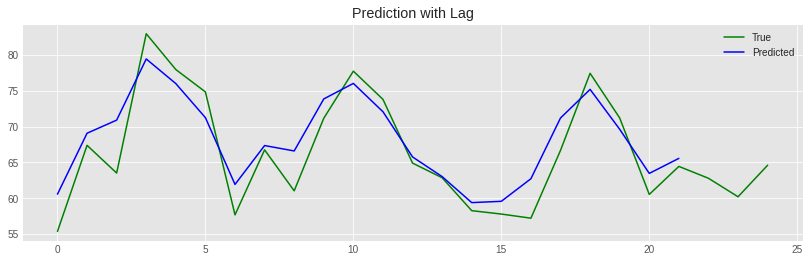

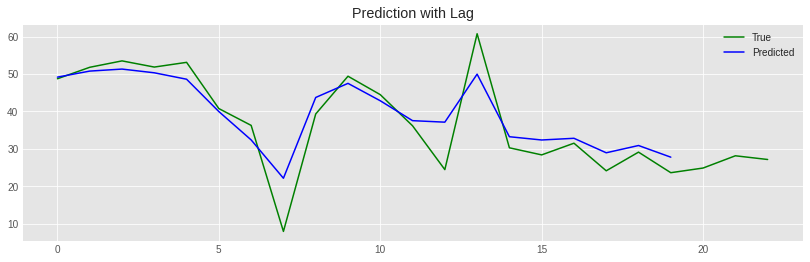

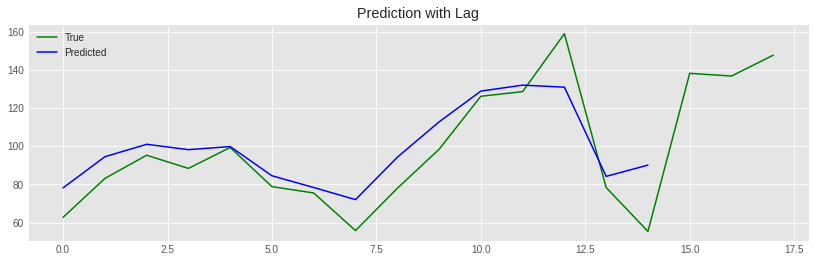

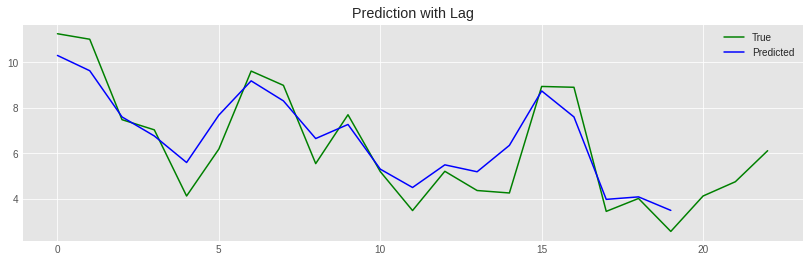

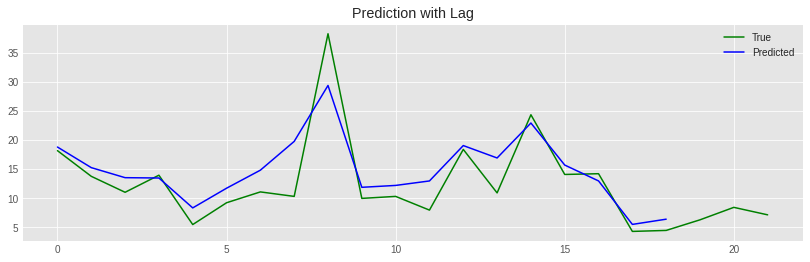

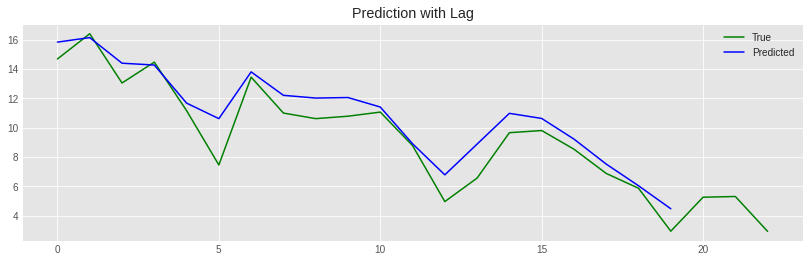

In [27]:
total_error["Cases"] = 0
for country in training_countries:
  print(country)
  total_error["Cases"] += lagging(pred_result_cases[country], -3)

MSE with Lag    : 0.539008043634711
MSE with Lag    : 1.5127674262829558
MSE with Lag    : 1.3405606432972788
MSE with Lag    : 0.018489180988322147
MSE with Lag    : 17.341834650289517
MSE with Lag    : 0.23038042592575925


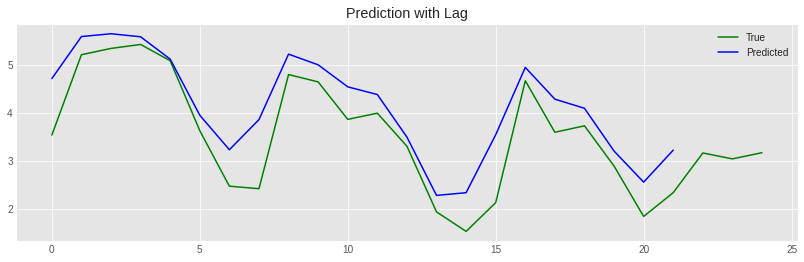

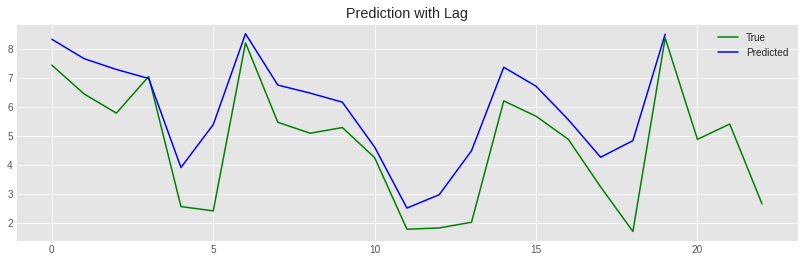

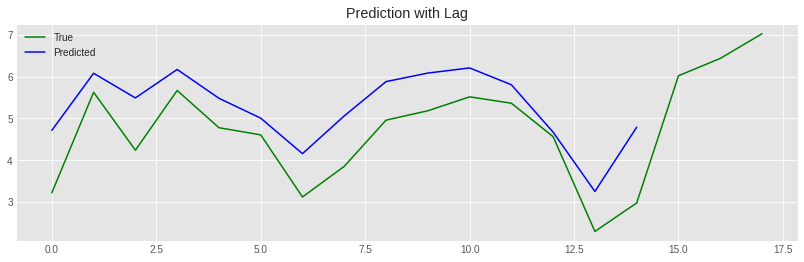

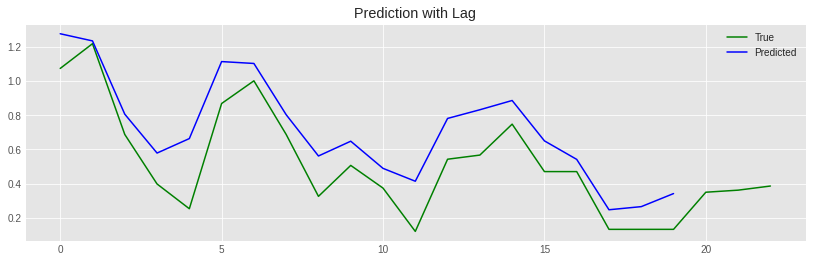

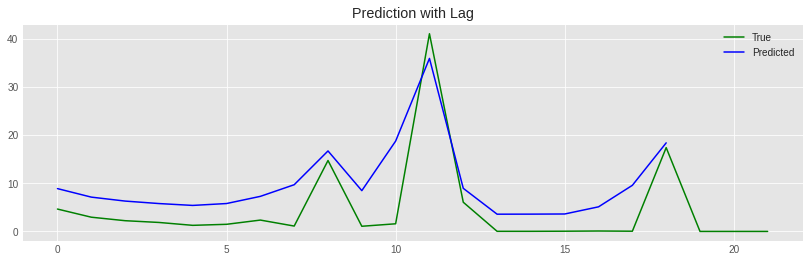

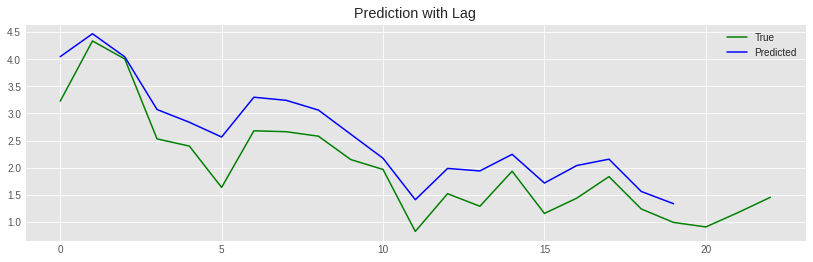

In [28]:
total_error["Deaths"] = 0
for country in training_countries:
  total_error["Deaths"] +=lagging(pred_result_deaths[country], -3)

In [29]:
FILE = open('LSTMcases.pickle', 'wb')
pickle.dump(regressorLSTM_cases, FILE)
FILE.close()

FILE = open('LSTMdeaths.pickle', 'wb')
pickle.dump(regressorLSTM_deaths, FILE)
FILE.close()

In [30]:
print(total_error)

{'Cases': 168.4883465868499, 'Deaths': 20.983040370418543}


In [31]:
print(total_accuracy)

{'cases': 0.18412855987747512, 'deaths': 0.3293114160497983}


In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
df_latest = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data.csv')
df_latest.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,12-06-2020,12,6,2020,747,21,Afghanistan,AF,AFG,37172386.0,Asia
1,11-06-2020,11,6,2020,684,21,Afghanistan,AF,AFG,37172386.0,Asia
2,10-06-2020,10,6,2020,542,15,Afghanistan,AF,AFG,37172386.0,Asia
3,09-06-2020,9,6,2020,575,12,Afghanistan,AF,AFG,37172386.0,Asia
4,08-06-2020,8,6,2020,791,30,Afghanistan,AF,AFG,37172386.0,Asia


In [34]:
FILE = open('LSTMcases.pickle', 'rb')
LSTM_cases = pickle.load(FILE)
FILE.close()

FILE = open('LSTMdeaths.pickle', 'rb')
LSTM_deaths = pickle.load(FILE)
FILE.close()

In [35]:
grouped = df_latest.groupby('countriesAndTerritories')
countries=sorted(list(set(df_latest.countriesAndTerritories.unique())))
country_population = {}
for country in countries:
  country_population[country]=set(grouped.get_group(country)['popData2018'])
countries_to_remove = ["Cases_on_an_international_conveyance_Japan", "Holy_See"]
for country in countries:
  if len(country_population[country])>1 :
    countries_to_remove.append(country)
for country in countries_to_remove:
  del country_population[country]
  countries.remove(country)

country_population = {}
for country in countries:
  country_population[country]=list(grouped.get_group(country)['popData2018'])[0]

In [36]:
country_wise_cases=dict()
country_wise_deaths=dict()
normalised_country_wise_cases=dict()
normalised_country_wise_deaths=dict()
for country in countries:
  country_wise_cases[country]=list(grouped.get_group(country)['cases'])[::-1]
  country_wise_deaths[country]=list(grouped.get_group(country)['deaths'])[::-1]
for country in countries:
  for index in range(len(country_wise_cases[country])):
    country_wise_cases[country][index] = abs(country_wise_cases[country][index])
    country_wise_deaths[country][index] = abs(country_wise_deaths[country][index])

for country in countries:
  leading_zero_count = 0
  for index in range(len(country_wise_cases[country])):
    if country_wise_cases[country][index] == 0:
      leading_zero_count += 1
    else:
      country_wise_cases[country] = country_wise_cases[country][leading_zero_count:]
      country_wise_deaths[country] = country_wise_deaths[country][leading_zero_count:]
      break

In [37]:
for country in countries:
  normalised_country_wise_cases[country] = deepcopy(country_wise_cases[country])
  for index in range(len(country_wise_cases[country])):
    normalised_country_wise_cases[country][index] = normalised_country_wise_cases[country][index] * 1_000_000 / country_population[country]

for country in countries:
  normalised_country_wise_deaths[country] = deepcopy(country_wise_deaths[country])
  for index in range(len((country_wise_deaths[country]))):
    normalised_country_wise_deaths[country][index] = normalised_country_wise_deaths[country][index] * 1_000_000 / country_population[country]

In [38]:
cumulative_country_wise_cases=dict()
cumulative_country_wise_deaths=dict()
normalised_cumulative_country_wise_cases=dict()
normalised_cumulative_country_wise_deaths=dict()

for country in countries:
  cumulative_country_wise_cases[country] = []
  cumulative_country_wise_deaths[country] = []
  cumulative_cases = 0
  cumulative_death = 0
  normalised_cumulative_country_wise_cases[country] = []
  normalised_cumulative_country_wise_deaths[country] = []
  normalised_cumulative_cases = 0
  normalised_cumulative_death = 0
  total_days = len(country_wise_cases[country])
  for index in range(total_days):
    cumulative_cases += country_wise_cases[country][index]
    cumulative_death += country_wise_deaths[country][index]
    cumulative_country_wise_cases[country].append(cumulative_cases)
    cumulative_country_wise_deaths[country].append(cumulative_death)
    normalised_cumulative_cases += normalised_country_wise_cases[country][index]
    normalised_cumulative_death += normalised_country_wise_deaths[country][index]
    normalised_cumulative_country_wise_cases[country].append(normalised_cumulative_cases)
    normalised_cumulative_country_wise_deaths[country].append(normalised_cumulative_death)

In [39]:
for country in countries:
  print("{0:45s}".format(country),"{0:10d}".format(cumulative_country_wise_cases[country][-1]),"{0:10d}".format(cumulative_country_wise_deaths[country][-1]))

Afghanistan                                        22890        426
Albania                                             1385         35
Algeria                                            10589        741
Andorra                                              852         51
Angola                                               118          5
Antigua_and_Barbuda                                   26          3
Argentina                                          27360        765
Armenia                                            14669        245
Aruba                                                101          3
Australia                                           7285        102
Austria                                            16964        674
Azerbaijan                                          8882        108
Bahamas                                              103         11
Bahrain                                            17269         36
Bangladesh                                      

In [40]:
top_n = 10
countries_and_cases=[]
countries_and_deaths=[]

for country,cumulative_cases in zip(cumulative_country_wise_cases.keys(),cumulative_country_wise_cases.values()):
  countries_and_cases.append([country,cumulative_cases[-1]])
countries_and_cases=sorted(countries_and_cases,key=lambda x:x[1],reverse=True)
top_n_cases=list(map(lambda x:x[0],countries_and_cases))[:top_n]

for country,cumulative_deaths in zip(cumulative_country_wise_deaths.keys(),cumulative_country_wise_deaths.values()):
  countries_and_deaths.append([country,cumulative_deaths[-1]])
countries_and_deaths=sorted(countries_and_deaths,key=lambda x:x[1],reverse=True)

top_n_deaths=list(map(lambda x:x[0],countries_and_deaths))[:top_n]

print("{0:45s}".format("Total Cases"), "{0:45s}".format("Total Deaths"), end="\n\n")
for index in range(top_n):
  print("{0:45s}".format(top_n_cases[index]), "{0:45s}".format(top_n_deaths[index]))

def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 
training_countries = list(intersection(top_n_cases, top_n_deaths))
print(training_countries)

Total Cases                                   Total Deaths                                 

United_States_of_America                      United_States_of_America                     
Brazil                                        United_Kingdom                               
Russia                                        Brazil                                       
India                                         Italy                                        
United_Kingdom                                Spain                                        
Spain                                         France                                       
Italy                                         Mexico                                       
Peru                                          Belgium                                      
Germany                                       Germany                                      
Iran                                          Iran                             

In [41]:
base_data_cases = normalised_country_wise_cases
base_data_deaths = normalised_country_wise_deaths

def split(dataframe, split_factor):
  base_data = {}
  for country in training_countries:
    base_data[country] = {}
    country_data_length = len(dataframe[country])
    split_index = int(math.floor(country_data_length * split_factor))
    base_data[country]["Train"] = dataframe[country][:split_index]
    base_data[country]["Test"] = dataframe[country][split_index:]
  return base_data

split_factor = 0.8

transform_train_cases = {}
transform_test_cases = {}
scaler_cases = {}
data_cases = split(base_data_cases, split_factor)
for num, country in enumerate(training_countries):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(data_cases[country]["Train"])
    a1 = np.array(data_cases[country]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train_cases[country] = sc.fit_transform(a0)
    transform_test_cases[country] = sc.fit_transform(a1)
    scaler_cases[country] = sc
del a0
del a1

transform_train_deaths = {}
transform_test_deaths = {}
scaler_deaths = {}
data_deaths = split(base_data_deaths, split_factor)
for num, country in enumerate(training_countries):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(data_deaths[country]["Train"])
    a1 = np.array(data_deaths[country]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train_deaths[country] = sc.fit_transform(a0)
    transform_test_deaths[country] = sc.fit_transform(a1)
    scaler_deaths[country] = sc
del a0
del a1

In [42]:
for i in transform_train_cases.keys():
    print(i, transform_train_cases[i].shape)
print("\n")    
for i in transform_test_cases.keys():
    print(i, transform_test_cases[i].shape)
 
print("\n")    
for i in transform_train_deaths.keys():
    print(i, transform_train_deaths[i].shape)
print("\n")    
for i in transform_test_deaths.keys():
    print(i, transform_test_deaths[i].shape)

United_States_of_America (115, 1)
United_Kingdom (107, 1)
Brazil (86, 1)
Germany (109, 1)
Spain (105, 1)
Iran (91, 1)
Italy (107, 1)


United_States_of_America (29, 1)
United_Kingdom (27, 1)
Brazil (22, 1)
Germany (28, 1)
Spain (27, 1)
Iran (23, 1)
Italy (27, 1)


United_States_of_America (115, 1)
United_Kingdom (107, 1)
Brazil (86, 1)
Germany (109, 1)
Spain (105, 1)
Iran (91, 1)
Italy (107, 1)


United_States_of_America (29, 1)
United_Kingdom (27, 1)
Brazil (22, 1)
Germany (28, 1)
Spain (27, 1)
Iran (23, 1)
Italy (27, 1)


In [43]:
trainset_cases = {}
testset_cases = {}
look_back_cases = 3
for country in training_countries:
    trainset_cases[country] = {}
    X_train = []
    y_train = []
    for i in range(look_back_cases, len(transform_train_cases[country])):
        X_train.append(transform_train_cases[country][i-look_back_cases:i,0])
        y_train.append(transform_train_cases[country][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset_cases[country]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset_cases[country]["y"] = y_train
    
    testset_cases[country] = {}
    X_test = []
    y_test = []    
    for i in range(look_back_cases, len(transform_test_cases[country])):
        X_test.append(transform_test_cases[country][i-look_back_cases:i,0])
        y_test.append(transform_test_cases[country][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset_cases[country]["X"] = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    testset_cases[country]["y"] = y_test

trainset_deaths = {}
testset_deaths = {}
look_back_deaths = 3
for country in training_countries:
    trainset_deaths[country] = {}
    X_train = []
    y_train = []
    for i in range(look_back_deaths, len(transform_train_deaths[country])):
        X_train.append(transform_train_deaths[country][i-look_back_deaths:i,0])
        y_train.append(transform_train_deaths[country][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset_deaths[country]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset_deaths[country]["y"] = y_train
    
    testset_deaths[country] = {}
    X_test = []
    y_test = []    
    for i in range(look_back_deaths, len(transform_test_deaths[country])):
        X_test.append(transform_test_deaths[country][i-look_back_deaths:i,0])
        y_test.append(transform_test_deaths[country][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset_deaths[country]["X"] = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    testset_deaths[country]["y"] = y_test

In [44]:
for country in training_countries:
  normalised_country_wise_cases[country] = np.array(normalised_country_wise_cases[country])
  normalised_country_wise_deaths[country] = np.array(normalised_country_wise_deaths[country])

In [45]:
pred_result_cases = {}
for country in training_countries:
  y_true = scaler_cases[country].inverse_transform(testset_cases[country]["y"].reshape(-1,1))
  y_pred = scaler_cases[country].inverse_transform(LSTM_cases.predict(testset_cases[country]["X"]))
  MSE = mean_squared_error(y_true, y_pred)
  pred_result_cases[country] = {}
  pred_result_cases[country]["True"] = y_true
  pred_result_cases[country]["Pred"] = y_pred

pred_result_deaths = {}
for country in training_countries:
  y_true = scaler_deaths[country].inverse_transform(testset_deaths[country]["y"].reshape(-1,1))
  y_pred = scaler_deaths[country].inverse_transform(LSTM_deaths.predict(testset_deaths[country]["X"]))
  MSE = mean_squared_error(y_true, y_pred)
  pred_result_deaths[country] = {}
  pred_result_deaths[country]["True"] = y_true
  pred_result_deaths[country]["Pred"] = y_pred

MSE with Lag    : 15.307360373528226
MSE with Lag    : 79.07644877111905
MSE with Lag    : 139.57126229798834
MSE with Lag    : 1.081096966385122
MSE with Lag    : 36.931782765625016
MSE with Lag    : 1.692836401800726
MSE with Lag    : 0.46029424110592226


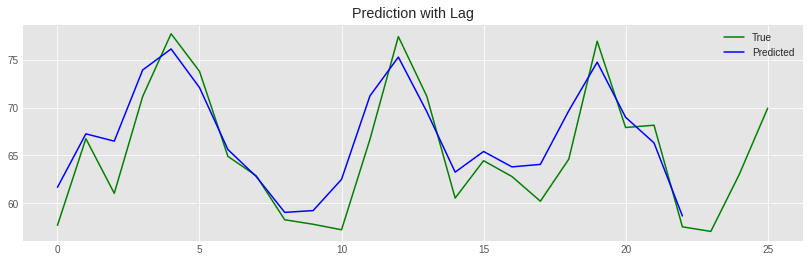

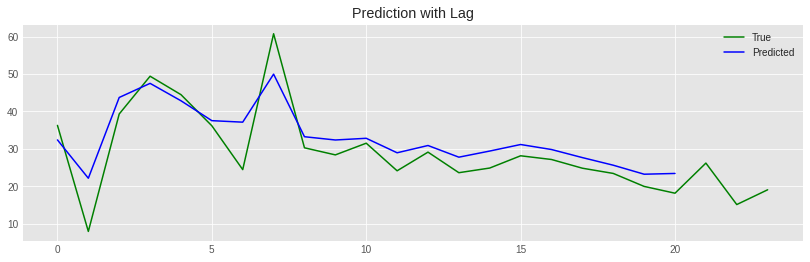

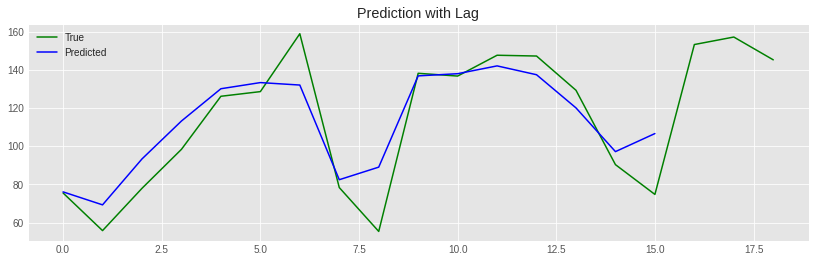

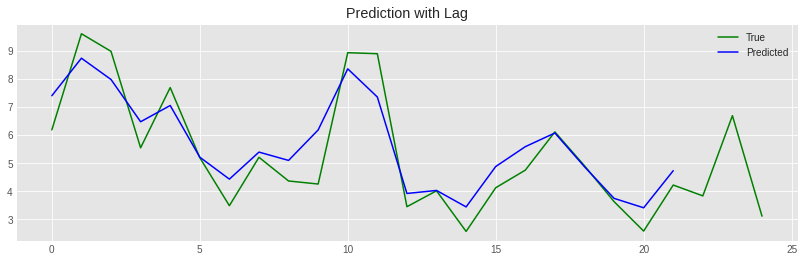

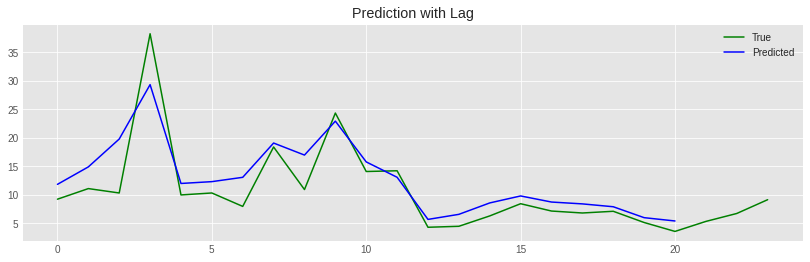

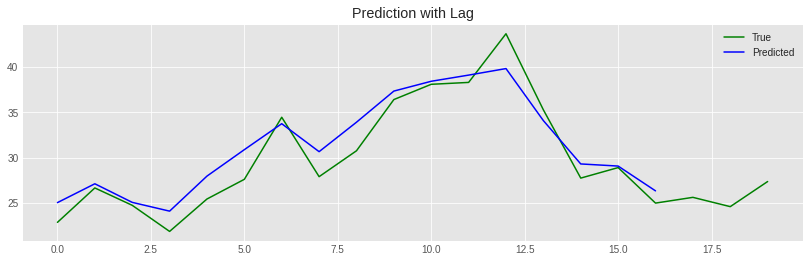

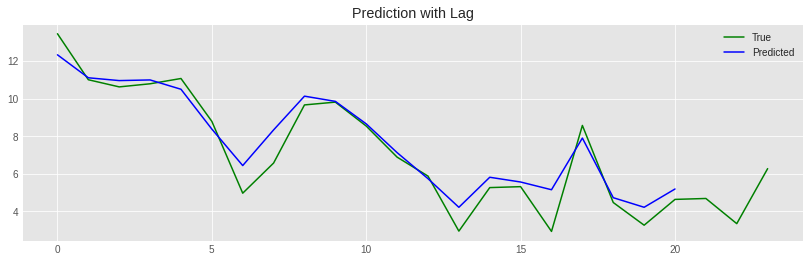

In [46]:
total_error["Cases"] = 0
for country in training_countries:
  total_error["Cases"] += lagging(pred_result_cases[country], -3)

MSE with Lag    : 0.9483974494531564
MSE with Lag    : 1.077849747525837
MSE with Lag    : 1.1319899414911294
MSE with Lag    : 0.006652905730771554
MSE with Lag    : 38.84742482618666
MSE with Lag    : 0.01174839219825515
MSE with Lag    : 0.01057538124793643


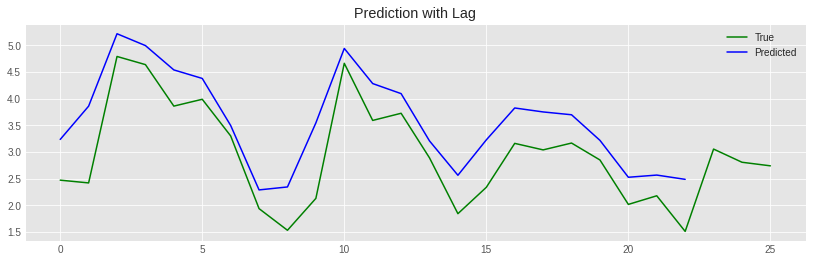

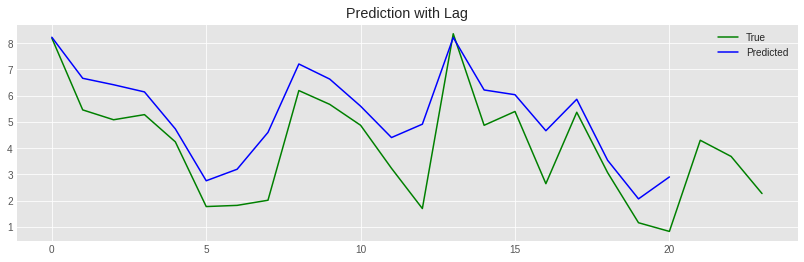

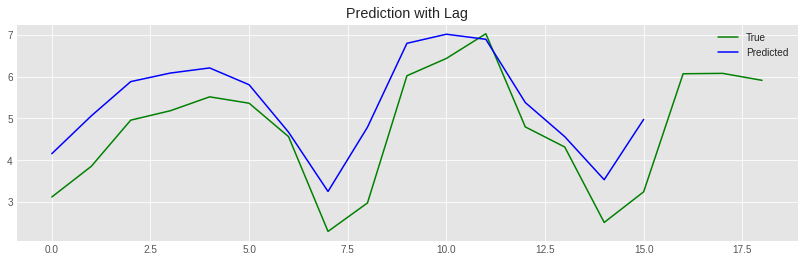

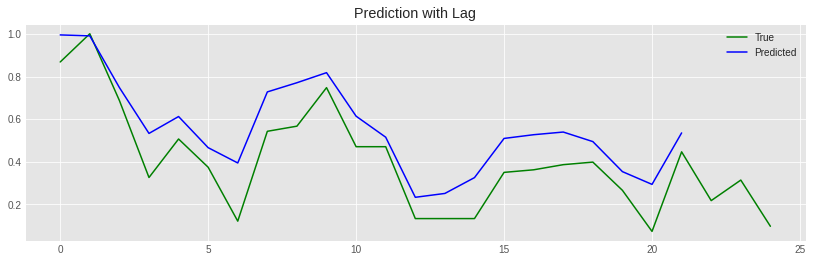

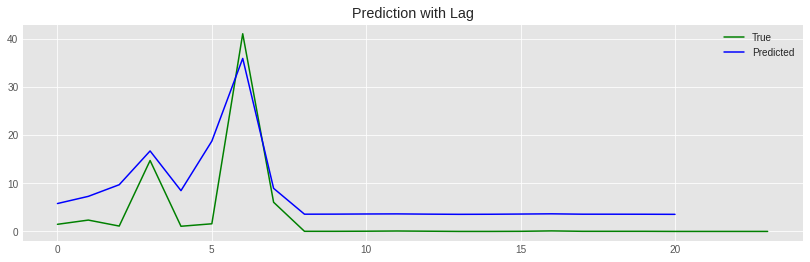

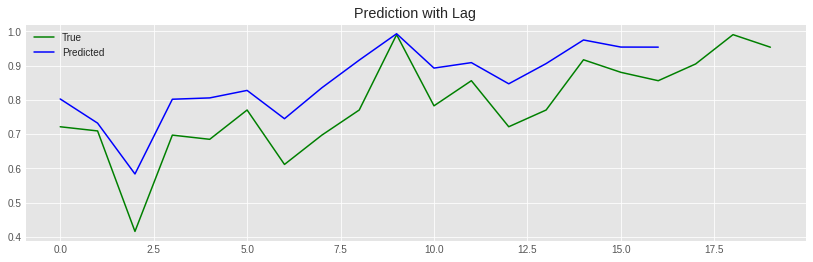

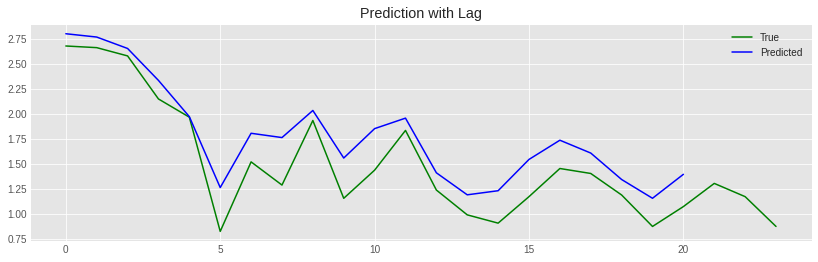

In [47]:
total_error["Deaths"] = 0
for country in training_countries:
  total_error["Deaths"] +=lagging(pred_result_deaths[country], -3)

In [48]:
print(total_error)

{'Cases': 274.1210818175524, 'Deaths': 42.03463864383375}
